In [1]:
import torch
import torch.autograd as autograd  # computation graph
from torch import Tensor  # tensor node in the computation graph
import torch.nn as nn  # neural networks
import torch.optim as optim  # optimizers e.g. gradient descent, ADAM, etc.

import numpy as np
from timeit import default_timer as timer
from pyDOE import lhs  # Latin Hypercube Sampling
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
import scipy.special
import itertools
from itertools import product

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

In [92]:
def exact(x, t):
    U = np.exp(-x) * np.cos(t)
    return U


def training_data_lhb(X, T, lb, ub, U_gt, N_boundary=20, N_inner=200):
    '''Boundary Conditions'''

    # Initial Condition lb[0] =< x =< ub[0] and t = lb[1]
    x_t_IC = np.vstack((X[0, :], T[0, :])).T
    u_IC = U_gt[:, 0][:, None]

    # Boundary Condition x = x_l and lb[1] =< t =< ub[1]
    x_t_BCl = np.vstack((X[:, 0], T[:, 0])).T
    u_BCl = U_gt[0, :][:, None]

    # Boundary Condition x = x_r and lb[1] =< t =< ub[1]
    x_t_BCr = np.vstack((X[:, -1], T[:, -1])).T
    u_BCr = U_gt[-1, :][:, None]

    # total Boundary
    x_t_boundary = np.vstack([x_t_IC, x_t_BCl, x_t_BCr])
    u_boundary = np.vstack([u_IC, u_BCl, u_BCr])

    # choose random N_u points for training
    idx = np.random.choice(x_t_boundary.shape[0], N_boundary, replace=False)
    x_t_boundary = x_t_boundary[idx, :]  # choose indices from  set 'idx' (x,t)
    u_boundary = u_boundary[idx, :]  # choose corresponding u

    '''Collocation Points'''

    # latin_hypercube
    x_t_train = lb + (ub - lb) * lhs(2, int(N_inner))

    return x_t_train, x_t_boundary, u_boundary

class Sequentialmodel(nn.Module):

    def __init__(self, layers, device):
        super().__init__()  # call __init__ from parent class
        self.layers = layers
        self.device = device
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        self.iter = 0
        self.G = 2
        #self.G = torch.tensor([2.3], requires_grad=True).to(device)
        #self.G = torch.nn.Parameter(self.G)
        self.M = 2
        self.N = 20  # Legendre基底个数
        self.N_G = 20  # Gauss-Legendre求积公式节点数
        self.alpha1= torch.tensor([1.2], requires_grad=True).to(device)
        self.alpha1= torch.nn.Parameter(self.alpha1)
        #self.alpha1 = 1.5
        self.s = 2

        # x_k 和 w_k是Gauss-Legendre求积公式的节点和权重
        self.x_k, self.w_k = scipy.special.roots_legendre(self.N_G + 1)

        self.w_k, self.x_k = torch.from_numpy(self.w_k).float(), torch.reshape(torch.from_numpy(self.x_k).float(),
                                                                               [self.N_G + 1, -1])
        self.L = torch.reshape(self.jacobi_polynomial(0, 0, self.x_k), [-1, self.N_G + 1])
        

        coe1 = []
        for j in range(self.N + 1):
            temp = torch.tensor((2 * j + 1) / 2)
            coe1.append(temp)
        self.coe1 = torch.vstack(coe1)
    

        'Xavier Normal Initialization'
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    'foward pass'

    def forward(self, x):
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x).float().to(self.device)

        for i in range(len(self.layers) - 2):
            z = self.linears[i](x)
            x = self.activation(z)

        output = self.linears[-1](x)
        
        return output


    def jacobi_polynomial(self, a, b, x):
        jacobi = [torch.ones(x.shape)]
        p0 = 1
        p1 = 1 / 2 * (a + b + 2) * x + 1 / 2 * (a - b)
        jacobi.append(p1)
        for i in range(1, self.N):
            A = (2 * i + a + b + 1) * (2 * i + a + b + 2) / (2 * (i + 1) * (i + a + b + 1))
            B = (b ** 2 - a ** 2) * (2 * i + a + b + 1) / (2 * (i + 1) * (i + a + b + 1) * (2 * i + a + b))
            C = (i + a) * (i + b) * (2 * i + a + b + 2) / ((i + 1) * (i + a + b + 1) * (2 * i + a + b))
            p = (A * x - B) * p1 - C * p0
            p0 = p1
            p1 = p
            jacobi.append(p1)
            # print("jacobi",jacobi)
        jacobi = torch.vstack(jacobi)
        return jacobi

    def fra_term(self, x):
        
        coe2 = []
        for j in range(self.N ):
            temp = torch.tensor(math.gamma(j + 2) / math.gamma(j - self.alpha1 + 2))
            coe2.append(temp)
        coe2 = torch.vstack(coe2)

        fra_jacobi_l = torch.reshape(self.jacobi_polynomial(self.alpha1, 1 - self.alpha1, x), [self.N + 1, -1])[:self.N,
                       :]
        Dl_n_result = coe2 * fra_jacobi_l @ torch.diag(torch.pow(1 + x, 1 - self.alpha1).squeeze(1))
        Dl_n_result = torch.flip(Dl_n_result, dims=[0])

        #fra_jacobi_r = torch.reshape(self.jacobi_polynomial(1 - self.alpha1, self.alpha1, x), [self.N + 1, -1])[:self.N,
        #               :]
        #Dr_n_result = coe2 * fra_jacobi_r @ torch.diag(torch.pow(1 - x, 1 - self.alpha1).squeeze(1))
        #Dr_n_result = torch.flip(Dr_n_result, dims=[0])

        return Dl_n_result #, Dr_n_result

    # 系数a_j
    def a_j(self, t):
        """
        a_j = sum(w_k * L_j(x_k) * e^{G*x_k} * f(x_k))
        """
        
        x_k_t = torch.cartesian_prod(self.x_k.squeeze(1), t.squeeze(1))
        
        W_l = torch.diag(self.w_k) * torch.diag(torch.exp(self.G * self.x_k).squeeze(1))
        #W_r = torch.diag(self.w_k) * torch.diag(torch.exp(- self.M * self.x_k).squeeze(1))
        Coeff_l = self.L @ W_l * self.coe1
        #Coeff_r = self.L @ W_r * self.coe1

        
        a_l = Coeff_l @ torch.reshape(torch.exp(-x_k_t[:, 0]) * torch.cos(x_k_t[:, -1]), [self.N_G + 1, -1])
        #a_r = Coeff_r @ torch.reshape(torch.exp(-x_k_t[:, 0]) * torch.cos(x_k_t[:, -1]), [self.N_G + 1, -1])
        #print("a_result",a_result)

        A_l = [a_l[self.N]]
        #A_r = [-a_r[self.N]]
        for i in range(self.N):
            temp_l = a_l[self.N - 1 - i] - A_l[i]
            A_l.append(temp_l)
            #temp_r = - a_r[self.N - 1 - i] + A_r[i]
            #A_r.append(temp_r)
        Al_result = torch.vstack(A_l)
        #Ar_result = torch.vstack(A_r)
        # print("A",A_result)
        # print("A[:-1]",A_result[:-1])

        return Al_result #, Ar_result

    def compute(self, x_t):
        x, t = x_t[:, 0][:, None], x_t[:, 1][:, None]

        #Al , Ar = self.a_j(t)
        Al = self.a_j(t)
        #Bl , Br = self.fra_term(x)
        Bl  = self.fra_term(x)
        
        coe3 = (1 / math.gamma(self.s - self.alpha1) * (self.s - self.alpha1 - 1))

        Cl = Al[:-1] * Bl
        Cl_sum = torch.sum(Cl, 0).unsqueeze(1)
        Cl0 = Al[-1].unsqueeze(1) * coe3 * pow(1 + x, self.s - self.alpha1 - 2)
        result_l = torch.exp(-self.G * x)*(Cl_sum + Cl0)

        #Cr = Ar[:-1] * Br
        #Cr_sum = torch.sum(Cr, 0).unsqueeze(1)
        #Cr0 = -Ar[-1].unsqueeze(1) * coe3 * pow(1 - x, self.s - self.alpha1 - 2)
        #result_r = torch.exp(self.M * x) * (Cr_sum + Cr0)
        return result_l #,result_r

    'non-homogeneous term for Loss'
    def fun_f(self, x_t):
        # print("x:",x)
        G, M, alpha1 = 2 , 2, 1.5
        x, t = x_t[:, 0][:, None], x_t[:, 1][:, None]
        a_l = G - 1
        a_r = M + 1
        k = alpha1 - self.s + 1

        m = 1 - k
        n_l = torch.mul(a_l, 1 + x)
        n_r = torch.mul(a_r, 1 - x)

        max_iter = 20  # 最大迭代次数
        result_l, result_r = 0.0, 0.0  # 结果初始化
        mul = 1
        for _ in range(max_iter):
            mul *= m + _
            # print("mul:",mul)
            term_l = torch.pow(n_l, _) / mul
            term_r = torch.pow(n_r, _) / mul
            result_l += term_l
            result_r += term_r
        result1 = math.gamma(m) - torch.pow(n_l, m) * torch.exp(-n_l) * result_l
        result2 = math.gamma(m) - torch.pow(n_r, m) * torch.exp(-n_r) * result_r

        # result1 = result1 * math.gamma(s - self.alpha1)
        # x = torch.from_numpy(x).float().to(self.device)
        #temp_l = a_l ** self.alpha1 * torch.exp(-x) * result1 - \
        #         a_l * torch.exp(-self.G * x - self.G + 1) * torch.pow(1 + x, (-self.alpha1 + 1)) + \
        #         (self.alpha1 - 1) * torch.exp(-self.G * x - self.G + 1) * torch.pow(1 + x, -self.alpha1)
        temp_l = a_l ** alpha1 * torch.exp(-x) * result1 - \
                  a_l * torch.exp(-G * x - G + 1) * torch.pow(1 + x, (-k)) + \
                 k * torch.exp(-self.G * x - G + 1) * torch.pow(1 + x, -k-1)
        left = a_l ** alpha1 * torch.exp(-x) - 1 / math.gamma(self.s - alpha1) * temp_l

        #temp_r = a_r ** self.alpha1 * torch.exp(-x) * result2 - \
        #         a_r * torch.exp(self.M * x - self.M - 1) * torch.pow(1 - x, (-self.alpha1 + 1)) + \
        #         (self.alpha1 - 1) * torch.exp(self.M * x - self.M - 1) * torch.pow(1 - x, -self.alpha1)
        temp_r = a_r ** alpha1 * torch.exp(-x) * result2 - \
                 a_r * torch.exp(M * x - M - 1) * torch.pow(1 - x, (-k)) + \
                 k * torch.exp(M * x - M - 1) * torch.pow(1 - x, -k-1)
        right = a_r ** alpha1 * torch.exp(-x) - 1 / math.gamma(self.s - alpha1) * temp_r

        #f = -torch.exp(-x)*torch.sin(t) -(left + right- pow(G, alpha1) * torch.exp(-x)- \
        #                                  pow(M, alpha1) * torch.exp(-x))*torch.cos(t)
        f = -torch.exp(-x)*torch.sin(t) -(left - pow(G, alpha1) * torch.exp(-x))*torch.cos(t)
        #f = (right-pow(self.M, self.alpha1) * torch.exp(-x))*torch.cos(t)
        # print("f:",f)
        return f

    'Eq term for Loss'

    def PDE(self, x_t):
        g = x_t
        g.requires_grad = True
        V = self.forward(g)
        V_real = (torch.exp(-g[:, 0]) * torch.cos(g[:, -1]))[:, None]
        L_loss = V - V_real
        
        V_x_t = autograd.grad(V, g, torch.ones([x_t.shape[0], 1]).to(self.device), retain_graph=True, create_graph=True)[0]
        V_t = V_x_t[:, [1]]

        f = self.fun_f(x_t)

        #D_l,D_r = self.compute(x_t)
        D_l = self.compute(x_t)
        #L_v =  V_t - D_l -D_r + pow(self.G, self.alpha1) * V + pow(self.M, self.alpha1) * V - f
        L_v =  V_t - D_l  + pow(self.G, self.alpha1) * V  - f
        #print(L_v)
        #L_v = D_r - pow(self.M, self.alpha1) * V - f
        return L_v, L_loss

    def loss(self, x_t_boundary, u_boundary, x_t):

        if torch.is_tensor(x_t) != True:
            x_t = torch.from_numpy(x_t).float().to(self.device)  # 把数组转换成张量，且二者共享内存

        if torch.is_tensor(x_t_boundary) != True:
            x_t_boundary = torch.from_numpy(x_t_boundary).float().to(self.device)

        if torch.is_tensor(u_boundary) != True:
            u_boundary = torch.from_numpy(u_boundary).float().to(self.device)

        loss_u = self.loss_function(self.forward(x_t_boundary), u_boundary)
        L_v, L_loss = self.PDE(x_t)
        loss_data = self.loss_function(L_loss, torch.zeros(L_loss.shape).to(self.device))
        loss_L_v = self.loss_function(L_v, torch.zeros(L_v.shape).to(self.device))
        loss = loss_u + loss_L_v + loss_data
        return  loss, loss_u , loss_L_v, loss_data

    def train_model_adam(self, optimizer, x_t_boundary, u_boundary, x_t_train, n_epoch):
        #G_pre =  [self.G.clone()]
        alpha_pre= [self.alpha1.clone()]
        while self.iter < n_epoch:
            optimizer.zero_grad()
            loss, loss_u , loss_L_v, loss_data = self.loss(x_t_boundary, u_boundary, x_t_train)
            loss.backward()

            if self.iter % 1000 == 0:
                print("paraments:G , M, alpha", self.G,self.M,self.alpha1)
                print(self.iter, loss, loss_u , loss_L_v, loss_data)
            #G_pre.append(self.G.clone())
            alpha_pre.append(self.alpha1.clone())
            self.iter += 1

            optimizer.step()
        
        #G_vec = torch.vstack(G_pre)
        alpha_vec = torch.vstack(alpha_pre)
        plt.plot(alpha_vec.detach().numpy(),'r',label='alpha')
        #plt.plot(G_vec.detach().numpy(),'b',label='G')
        plt.axhline(y=1.5,c='c',alpha = 0.4, linestyle='--')
        #plt.axhline(y=2.0,c='m',alpha = 0.4, linestyle='--')
        plt.legend()
        plt.xlabel('Iteration number')
        plt.ylabel('Value')
        #plt.yscale('log')
        plt.show()

    'test neural network'

    def test(self, x_t, u, N_xdata, N_tdata):

        if torch.is_tensor(u) != True:
            u = torch.from_numpy(u).float().to(self.device)

        u_pred = self.forward(x_t)
        error_vec = torch.linalg.norm((u - u_pred), 2) / torch.linalg.norm(u, 2)

        # a = u-u_pred

        print("error_vec:", error_vec)

        u_pred = u_pred.cpu().detach().numpy()
        u_pred = np.reshape(u_pred, (N_xdata, N_tdata), order='F')

        return error_vec, u_pred

X： (100, 100)
T： (100, 100)
size of (x, t): (100, 100)
paraments:G , M, alpha 2 2 Parameter containing:
tensor([1.2000], requires_grad=True)
0 tensor(76.7985, grad_fn=<AddBackward0>) tensor(3.1776, grad_fn=<MseLossBackward0>) tensor(71.9237, grad_fn=<MseLossBackward0>) tensor(1.6971, grad_fn=<MseLossBackward0>)
paraments:G , M, alpha 2 2 Parameter containing:
tensor([1.2929], requires_grad=True)
1000 tensor(17.7634, grad_fn=<AddBackward0>) tensor(0.4270, grad_fn=<MseLossBackward0>) tensor(17.0849, grad_fn=<MseLossBackward0>) tensor(0.2516, grad_fn=<MseLossBackward0>)
paraments:G , M, alpha 2 2 Parameter containing:
tensor([1.3706], requires_grad=True)
2000 tensor(4.4969, grad_fn=<AddBackward0>) tensor(0.0433, grad_fn=<MseLossBackward0>) tensor(4.3724, grad_fn=<MseLossBackward0>) tensor(0.0812, grad_fn=<MseLossBackward0>)
paraments:G , M, alpha 2 2 Parameter containing:
tensor([1.4230], requires_grad=True)
3000 tensor(0.7902, grad_fn=<AddBackward0>) tensor(0.0222, grad_fn=<MseLossBackwa

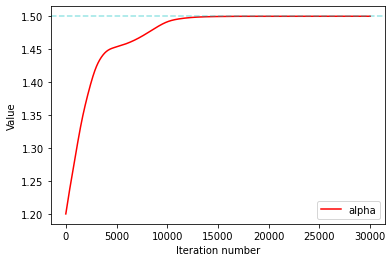

consumed time: 705.6926898797974s
error_vec: tensor(0.0001, grad_fn=<DivBackward0>)
Test Error: 0.00014


In [99]:
x_l = -1
x_r = 1
N_xdata = 100

t_0 = 0
t_T = 0.1
N_tdata = 100

x = np.linspace(x_l, x_r, N_xdata) # x_r = 4
t = np.linspace(t_0, t_T, N_tdata)
X , T = np.meshgrid(x,t)
print("X：",X.shape)
print("T：",T.shape)
U_gt = exact(X,T).T
print("size of (x, t):", U_gt.shape)
# plot_u(U_gt, x, t)

# test dataset
x_t_test = np.vstack((X.flatten(), T.flatten())).T
u_test = U_gt.flatten('F')[:,None]

# training dataset

N_boundary = 5
N_inner = 30

lb = np.array([x_l,t_0])
ub = np.array([x_r,t_T])
x_t_train, x_t_boundary, u_boundary = training_data_lhb(X, T, lb, ub, U_gt, N_boundary, N_inner)

# Device configuration
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')

if device == 'mps':
    print(torch.cuda.get_device_name())

layers = np.array([2,20,20,20,20,1]) #4 hidden layers
PINN = Sequentialmodel(layers, device)

PINN.to(device)
# print(PINN)


optimizer = torch.optim.Adam(PINN.parameters(), lr = 0.0001)

start = timer()
PINN.train_model_adam(optimizer, x_t_boundary, u_boundary, x_t_train, 3e4)
end = timer()
print("consumed time: " + str(end - start) + "s")

error_vec, u_pred = PINN.test(x_t_test, u_test, N_xdata, N_tdata)
print('Test Error: %.5f'  % (error_vec))

<Figure size 432x288 with 0 Axes>

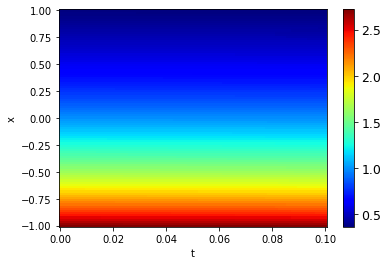

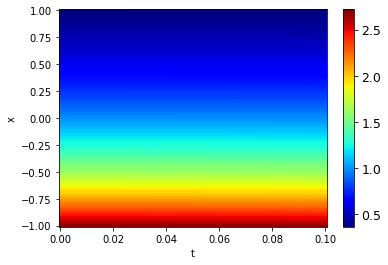

In [100]:
fig1 = plt.figure()
fig2 = plt.figure()
#ax1 = fig1.add_subplot(111, projection='3d')
#ax2 = fig2.add_subplot(111, projection='3d')
#print(x_t_test[:(N_xdata + 1)**2,0])
x = np.linspace(x_l, x_r, N_xdata )  # x取值范围和精度
t = np.linspace(t_0, t_T, N_tdata)  # y取值范围和精度
X, T = np.meshgrid(x, t) 
#print(x)
#print(y)
z1 = np.exp(-X)* np.cos(T) 
#print(z1)

#z2 =np.reshape(u_pred[:(N_xdata + 1)**2],[N_xdata + 1,N_xdata + 1])
plt.pcolor(t ,x, z1.T, cmap='jet')
plt.xlabel("t")
plt.ylabel("x")
clb = plt.colorbar()
clb.ax.tick_params(labelsize=12.5)
plt.savefig("real.jpg")
plt.show()

plt.pcolor(t, x, u_pred, cmap='jet')
plt.xlabel("t")
plt.ylabel("x")
clb = plt.colorbar()
clb.ax.tick_params(labelsize=12.5)
plt.savefig("predict_inv.jpg")
plt.show()

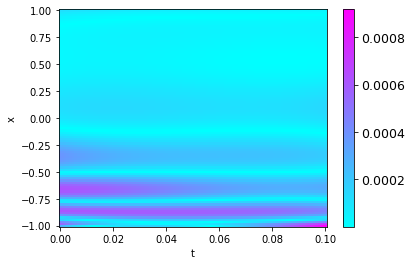

In [103]:
error = abs(z1.T-u_pred)
#print(error)
plt.pcolor(t, x,error ,cmap="cool")
clb = plt.colorbar()
plt.xlabel("t")
plt.ylabel("x")
clb.ax.tick_params(labelsize=12.5)
plt.savefig("error_inv.jpg")
plt.show()